# ViT for MNIST 

"AN IMAGE IS WORTH 16X16 WORDS:  TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE": <br>
https://arxiv.org/pdf/2010.11929 

This paper was published after the transformer architecture had become the standard within NLP. This paper showed that not only could transformers be applied to computer vision, but it beats standard CNNs in complicated image classification tasks. Th paper introduces the Visual Transformer (ViT). 

Note that: 
- Initial attempts tried to use CNNs with attention mechanism has been tried, but where not scalable. 
- Transformers can be trained on 100B parameters! 
- Inductive bias from the transformer is handled by providing large dataset 
- ViTs had great results, but they where pre-trained on large datasets (14 to 300 million images)


It works well by making the images into patches and then turn them into embeddings to input to the transformer. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

## Data

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.33MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 271kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.78MB/s]


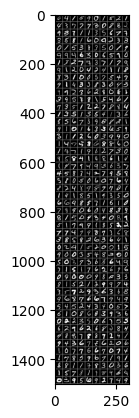

In [2]:
# Folder where the dataset is used
data_set_root = "../data"

# Downloading the mnist (training set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Selecting randomly 500 examples
number_of_examples = 500
rand_perm = torch.randperm(dataset.data.shape[0])[:number_of_examples]
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1,-1) for i in rand_perm])

out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose(1,2,0))

## Model

For making the ViT work as expected we use the Transformer. The transformers only works with 1D sequence of token embeddings. For images, we need to create the patches. This is done by reshaping each image into a sequence of 2D patches. 

